In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [ ]:
!pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"a01378649","key":"154794c7be64eb0d3e162c8fd07e93e5"}'}

In [ ]:
# Crear dirección para el API de Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# Cambiar a ejecutable
!chmod 600 ~/.kaggle/kaggle.json

# Confirmar conexión a Kaggle
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           5340        175  1.0              
kaggleashwin/population-dataset                                World Population by Countries Dataset (1960-2021)    69KB  2022-08-31 05:30:26           1579         70  1.0              
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03          11441        298  1.0              
pantanjali/unemployment-dataset                                Un

In [ ]:
# Descargar dataset
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 70.8MB/s]


In [ ]:
# Abrir zip
!unzip spaceship-titanic.zip -d "/content/kaggledb"

Archive:  spaceship-titanic.zip
  inflating: /content/kaggledb/sample_submission.csv  
  inflating: /content/kaggledb/test.csv  
  inflating: /content/kaggledb/train.csv  


In [ ]:
def generate_processed_dataframe(path):

    # Cargar datos
    df=pd.read_csv(path)

    # Crear nuevo dataframe para limpieza
    dfCl = df.copy()


    # Datos númericos = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

    
    filler6 = dfCl[dfCl["CryoSleep"]==True]["RoomService"].fillna(0.0)
    dfCl["RoomService"].loc[filler6.index] = filler6
    
    filler7 = dfCl[dfCl["CryoSleep"]==True]["FoodCourt"].fillna(0.0)
    dfCl["FoodCourt"].loc[filler7.index] = filler7
    
    filler8 = dfCl[dfCl["CryoSleep"]==True]["ShoppingMall"].fillna(0.0)
    dfCl["ShoppingMall"].loc[filler8.index] = filler8
    
    filler9 = dfCl[dfCl["CryoSleep"]==True]["Spa"].fillna(0.0)
    dfCl["Spa"].loc[filler9.index] = filler9

    
    filler10 = dfCl[dfCl["CryoSleep"]==True]["VRDeck"].fillna(0.0)
    dfCl["VRDeck"].loc[filler10.index] = filler10

    # Separar datos numéricos
    numeric = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    dfNum = dfCl[numeric]

    # Cálculo de la media de las variables numéricas
    ageMean = dfNum['Age'].mean()
    roomServiceMean = dfNum['RoomService'].mean()
    foodCourtMean = dfNum['FoodCourt'].mean()
    shoppingMallMean = dfNum['ShoppingMall'].median()
    spaMean = dfNum['Spa'].median()
    VRDeckMean = dfNum['VRDeck'].median()

    # Imputación por sustitución de medias
    dfNum['Age'].fillna(value = ageMean, inplace = True)
    dfNum['RoomService'].fillna(value = roomServiceMean, inplace = True)
    dfNum['FoodCourt'].fillna(value = foodCourtMean, inplace = True)
    dfNum['ShoppingMall'].fillna(value = shoppingMallMean, inplace = True)
    dfNum['Spa'].fillna(value = spaMean, inplace = True)
    dfNum['VRDeck'].fillna(value = VRDeckMean, inplace = True)

    categorical_cols = ["PassengerId", "HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP", "Name"]
    df_categorical = dfCl[categorical_cols]


    df_categorical.drop(["PassengerId", "Name"], axis=1, inplace=True)


    df_categorical["Deck"] = df_categorical["Cabin"].str[0]
    
    filler1 = df_categorical[(df_categorical["Deck"] != "G") & (df_categorical["Deck"] != "F")]["HomePlanet"].fillna("Europa")
    df_categorical["HomePlanet"].loc[filler1.index] = filler1    
    
    filler2 = df_categorical[df_categorical["VIP"] == True]["HomePlanet"].fillna("Europa")
    df_categorical["HomePlanet"].loc[filler2.index] = filler2
    
    filler3 = df_categorical[df_categorical["HomePlanet"] == "Europa"]["Deck"].fillna("B")
    df_categorical["Deck"].loc[filler3.index] = filler3
    
    filler4 = df_categorical[df_categorical["HomePlanet"] == "Earth"]["Deck"].fillna("G")
    df_categorical["Deck"].loc[filler4.index] = filler4
    
    filler5 = dfCl[(dfCl["RoomService"]==0) & 
                   (dfCl["FoodCourt"]==0) & 
                   (dfCl["Spa"]==0) & 
                   (dfCl["ShoppingMall"]==0) & 
                   (dfCl["VRDeck"]==0)]["CryoSleep"].fillna(True)
    df_categorical["CryoSleep"].loc[filler5.index] = filler5


    #return df_categorical
    
    for column in df_categorical:
        df_categorical[column].fillna(df_categorical[column].mode()[0], inplace=True)
        
    # Índice del dataframe limpio sin variable nombre
    index = df_categorical.index
    print(index)

    # Unir el dataframe
    df_junto = pd.DataFrame()

    # Agregar variables en orden
    df_junto['PassengerId'] = df.loc[index]['PassengerId']
    df_junto['HomePlanet'] = df_categorical['HomePlanet'] 
    df_junto['CryoSleep'] = df_categorical['CryoSleep']
    df_junto['Cabin'] = df_categorical['Cabin']
    df_junto['Destination'] = df_categorical['Destination']
    df_junto["Deck"] = df_categorical["Deck"]

    df_junto['Age'] = dfNum['Age']
    df_junto['VIP'] = df_categorical['VIP']
    df_junto['RoomService'] = dfNum['RoomService']
    df_junto['FoodCourt'] = dfNum['FoodCourt']
    df_junto['ShoppingMall'] = dfNum['ShoppingMall']
    df_junto['Spa'] = dfNum['Spa']
    df_junto['VRDeck'] = dfNum['VRDeck']
    try:
      df_junto['Transported'] = df.loc[index]['Transported']
    except:
      pass

    clean_df = df_junto.copy()

    # Crear dummie variables de 'HomePLanet' y 'Destination' y deck
    clean_df = pd.concat([clean_df, pd.get_dummies(clean_df['HomePlanet']).rename(columns=lambda x: 'HomePlanet_' + str(x))], axis=1)
    clean_df['Destination'] = clean_df['Destination'].replace({'PSO J318.5-22': 'PSOJ318.5-22', '55 Cancri e': '55Cancrie'})
    clean_df = pd.concat([clean_df, pd.get_dummies(clean_df['Destination']).rename(columns=lambda x: 'Destination_' + str(x))], axis=1)

    clean_df = pd.concat([clean_df, pd.get_dummies(clean_df["Deck"])], axis=1)


    # Reemplazar valores categóricos True/False a numéricos 1/0
    clean_df['CryoSleep'] = clean_df['CryoSleep'].replace({True: 1, False: 0})
    clean_df['VIP'] = clean_df['VIP'].replace({True: 1, False: 0})
    try:
      clean_df['Transported'] = clean_df['Transported'].replace({True: 1, False: 0})
    except:
      pass

    clean_df = clean_df.drop(columns=['HomePlanet', 'Destination'])

    # Creación de nueva columna 'Group' según 'PassengerId'
    clean_df['Group'] = 0
    for i in index:
      clean_df['Group'].loc[i] = clean_df['PassengerId'].loc[i][:4]

    # Creación de nueva columna 'NumGroup' según 'PassengerId'
    clean_df['NumGroup'] = 0
    clean_df['NumGroup']
    for i in index:
      clean_df['NumGroup'].loc[i] = clean_df['PassengerId'].loc[i][-2:]

    clean_df = pd.concat([clean_df, pd.get_dummies(clean_df["NumGroup"])], axis=1)
    clean_df.drop("NumGroup", axis=1, inplace=True)

    # Creación de nueva columna 'Side' según 'Cabin'
    clean_df['Side'] = 0
    for i in index:
      clean_df['Side'].loc[i] = clean_df['Cabin'].loc[i][-1:]
    #clean_df['Side'] = clean_df['Side'].replace({'P': 1, 'S': 0})
    
    clean_df = pd.concat([clean_df, pd.get_dummies(clean_df["Side"])], axis=1)

    # Creación de nueva columna 'TotalBill' según 'RoomService,	FoodCourt,	ShoppingMall,	Spa,	VRDeck'
    clean_df['TotalBill'] = 0
    for i in index:
      clean_df['TotalBill'].loc[i] = clean_df['RoomService'].loc[i] + clean_df['FoodCourt'].loc[i] + clean_df['ShoppingMall'].loc[i] + clean_df['Spa'].loc[i] + clean_df['VRDeck'].loc[i]

    clean_df.drop("Side", axis=1, inplace=True)
    #for numeric_col in numeric:
    #    clean_df[numeric_col] = (clean_df[numeric_col] - clean_df[numeric_col].min()) / (clean_df[numeric_col].max() - clean_df[numeric_col].min())
    #return clean_df

    #return clean_df
    # Creación de nueva columna 'Side' según 'Cabin'
    #clean_df['Deck'] = 0
    #for i in index:
    #  clean_df['Deck'].loc[i] = clean_df['Cabin'].loc[i][-1:]
    #clean_df['Side'] = clean_df['Side'].replace({'P': 1, 'S': 0})
    clean_df["constant"] = 1

    X = np.array(clean_df[["CryoSleep", "RoomService", "Spa", "VRDeck", "VIP", "FoodCourt",
                           "C", "E", "D", "B", "T",
                           "HomePlanet_Europa",
                           "Age",
                           "TotalBill",
                           "S",
                           #"P",
                           "ShoppingMall",
                           "Destination_55Cancrie",
                           "Destination_PSOJ318.5-22",
                           "Destination_TRAPPIST-1e",
                           "A",
                           "HomePlanet_Earth",
                           "HomePlanet_Mars",
                           "01",
                           #"02",
                           #"03",
                           #"04",
                           #"05",
                           #"06",
                           #"07",
                           "08",
                           "constant"
                           ]])
    #,"B", "C", "D", "E", "F", "G", "T"]])
                      
    """"RoomService", "Spa", "Age", "FoodCourt", "CryoSleep", "VIP", "VRDeck",
                                "ShoppingMall", "HomePlanet_Earth", "HomePlanet_Europa", "HomePlanet_Mars",
                                "Destination_55Cancrie", "Destination_PSOJ318.5-22", "Destination_TRAPPIST-1e",
                                "Side", "TotalBill", "A", "B", "C", "D", "E", "F", "G"]])"""
    #y = clean_df["Transported"]


    return X, clean_df

In [ ]:
model = joblib.load("/content/modelo_preliminar.joblib")

In [ ]:
Xt, dft = generate_processed_dataframe('/content/kaggledb/train.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors

RangeIndex(start=0, stop=8693, step=1)


In [ ]:
#Split original train set into train and test subsets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xt, dft['Transported'], train_size=0.8, random_state=69)


Generando Confusion-Matrix


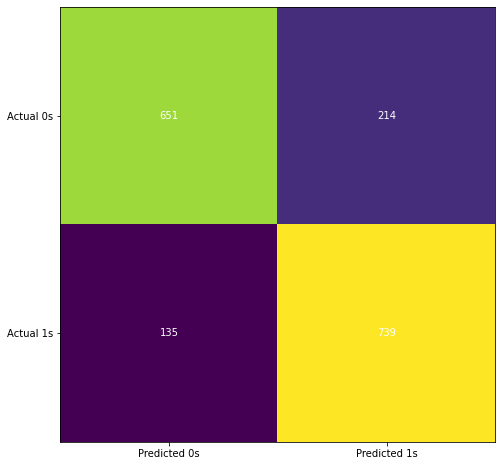

In [ ]:
#Generate confusion matrix for passenger classification (transported or not)
from sklearn.metrics import classification_report, confusion_matrix

print("\nGenerando Confusion-Matrix")
cm = confusion_matrix(ytest, model.predict(Xtest))

# Mostrar matriz de confusion
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [ ]:
#Evaluation metrics computation
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
accuracy = (TP+TN)/(TP+TN+FN+FP)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
F1 = 2 * (precision*recall)/(precision+recall)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('Specifity: ', specifity)
print('F1: ', F1)

Accuracy:  0.7993099482461185
Precision:  0.7754459601259182
Recall:  0.8455377574370709
Specifity:  0.7526011560693642
F1:  0.8089764641488779


In [ ]:
#Defining ROC curve plot for comparison
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='Logistic')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

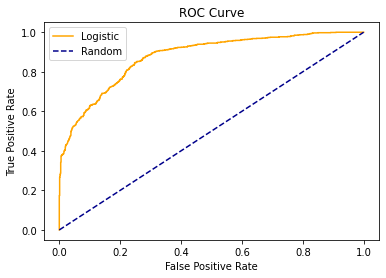

In [ ]:
#Generate  ROC curve by computing the probabilities using trained model over test data
from sklearn.metrics import roc_curve 
p = model.predict_proba(Xtest)  
p = p[:, 1]  
FPR, TPR, thresholds = roc_curve(ytest, p) 
plot_roc_cur(FPR, TPR)

In [ ]:
#Compute AUC to specify performance via ROC
from sklearn import metrics
metrics.auc(FPR, TPR)

0.8769897223581699